<a href="https://colab.research.google.com/github/TayJen/hackathon_algu2022/blob/master/H_ALGU_2022_Advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
%cd /content/drive/Shareddrives/data_drive/H_Vladivostok2022
!pwd

/content/drive/Shareddrives/data_drive/H_Vladivostok2022
/content/drive/Shareddrives/data_drive/H_Vladivostok2022


## Импорт библиотек

In [86]:
# Для работы с данными
import numpy as np
import pandas as pd

# Для визуализации
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Для работы с текстом
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.probability import FreqDist
from nltk.corpus import wordnet, stopwords
from pymystem3 import Mystem

# Для моделей
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

# Метрика
from sklearn.metrics import r2_score

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'
np.random.seed(59)

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Работа с данными

## Основные данные

Считаем данные

In [87]:
df = pd.read_csv("./data/train/train_issues.csv")

Работа со временем

In [88]:
df['created_time'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')
df['month'] = df['created_time'].dt.month
df['day'] = df['created_time'].dt.day
df['hour'] = df['created_time'].dt.hour
df['minute'] = df['created_time'].dt.minute

df.drop(['created', 'created_time'], axis=1, inplace=True)

Работа с ключем задачи

In [89]:
df['key_name'] = df['key'].apply(lambda x: x.split('-')[0])
df['key_num'] = df['key'].apply(lambda x: x.split('-')[1]).astype('int64')

df.drop(['key'], axis=1, inplace=True)
df.head()

,id,summary,project_id,assignee_id,creator_id,overall_worklogs,month,day,hour,minute,key_name,key_num
0,819952,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,10,1,5,57,SM,10678
1,819949,"UI тесты раздела ""Профиль""",5,93,93,7200,10,1,5,59,SM,10679
2,819947,"UI тесты раздела ""Личный счет""",5,93,93,14400,10,1,6,0,SM,10680
3,819943,"UI тесты раздела ""Новости""",5,93,93,900,10,1,6,2,SM,10682
4,819941,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900,10,1,6,3,SM,10683


Работа с описанием задачи

In [92]:
m = Mystem()
lemmatizer = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

Для того чтобы лемматизация работала, необходимо раскомментировать первые две строки при первом запуске

In [93]:
# !wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
# !tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

In [94]:
def clear_text(text):
    t = re.sub(r'[^a-zA-Z0-9а-яА-ЯёЁ\' ]', ' ', text)
    t = ' '.join(t.split())
    return t

def lemmatize_text_rus(text):
    tokens = m.lemmatize(text.lower())
    tokens = [token for token in tokens if token != '\n']
    text = " ".join(tokens)
    
    return text

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize_with_pos_eng(text):
    pos_tagged = nltk.pos_tag(w_tokenizer.tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence


df['clear_summary'] = df['summary'].apply(clear_text)
df['clear_summary'] = df['clear_summary'].str.lower()
df['lemm_summary'] = df['clear_summary'].apply(lemmatize_text_rus)
df['lemm_summary'] = df['lemm_summary'].apply(lemmatize_with_pos_eng)

df.drop(['summary', 'clear_summary'], axis=1, inplace=True)

Эти стоп-слова пригодятся нам в дальнейшем при использовании tf-idf

In [95]:
stopwords_rus = stopwords.words("russian")
stopwords_eng = stopwords.words('english')
stopwords_all = stopwords_rus + stopwords_eng

count_tf_idf = TfidfVectorizer(stop_words=stopwords_all)

Преобразуем таргет, чтобы исключить выбросы и минимизировать разброс

In [96]:
df['log_target'] = np.log(df['overall_worklogs'])
df.drop(['overall_worklogs'], axis=1, inplace=True)

## Присоединяем дополнительные данные

### Информация о работниках

Считаем данные

In [97]:
df_emp = pd.read_csv("./data/employees.csv")

Сразу отбросим бесполезное

In [98]:
df_emp.drop(['english_level', 'salary_calculation_type', 'full_name'],
            axis=1, inplace=True)

In [99]:
df_emp['payment_type'].fillna('unknown', inplace=True)
df_emp['hiring_type'].fillna('unknown', inplace=True)

In [100]:
def position_cleaning(x):
    if x is np.NaN:
        return x
    
    x = x.lower().strip().replace('-', ' ')

    key_positions = ['web', 'директор', 'руководитель',
                     'devops', 'рекрутер', 'бухгалтер',
                     'hr', 'тестировщик']

    for key_pos in key_positions:
        if key_pos in x:
            x = key_pos
            break
    
    if x == 'рекрутер' or x == 'специалист отдела по управлению персоналом' or x == 'сорсер':
        return 'hr'
    elif x == 'графический дизайнер':
        return 'web'
    else:
        return x


df_emp['position'] = df_emp['position'].apply(position_cleaning)
pos_pop = df_emp['position'].value_counts()

In [101]:
def remark_pos(x):
    if x is np.NaN or pos_pop[x] < 3:
        return 'other'
    else:
        return x


df_emp['position'] = df_emp['position'].apply(remark_pos)
df_emp.head()

,id,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,1,1,other,unknown,unknown,0,0,0,0,0
1,2,0,web,staff,fixed,0,0,0,0,0
2,4,0,web,staff,fixed,0,0,0,0,0
3,6,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0
4,8,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1


Присоединяем информацию о работниках

In [102]:
df = pd.merge(df, df_emp, left_on="assignee_id", right_on="id",
              how='left', suffixes=('', '_y'))

# df.drop(['creator_id', 'assignee_id', 'id_y'], axis=1, inplace=True)
df.drop(['id_y'], axis=1, inplace=True)

In [103]:
df.head()

,id,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,...,log_target,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,819952,5,93,93,10,1,5,57,SM,10678,...,7.495542,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
1,819949,5,93,93,10,1,5,59,SM,10679,...,8.881836,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
2,819947,5,93,93,10,1,6,0,SM,10680,...,9.574983,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
3,819943,5,93,93,10,1,6,2,SM,10682,...,6.802395,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1
4,819941,5,93,93,10,1,6,3,SM,10683,...,6.802395,1,разработчик мобильных приложений,staff,fixed,1,1,1,1,1


### Информация о комментариях

In [104]:
df_coms = pd.read_csv("./data/train/train_comments.csv")

In [105]:
df_coms_counts = df_coms.groupby('issue_id').agg({'comment_id': 'count',
                                                  'author_id': 'nunique'})
df_coms_counts.reset_index(inplace=True)
df_coms_counts.rename(columns={"comment_id":"comments_cnt",
                               "author_id":"authors_cnt"},
                      inplace=True)
df_coms_counts.head()

,issue_id,comments_cnt,authors_cnt
0,669666,1,1
1,669670,1,1
2,670930,3,1
3,670934,3,1
4,675979,5,1


In [106]:
df = pd.merge(df, df_coms_counts, left_on="id", right_on="issue_id", how='left')
df.drop(['id', 'issue_id'], axis=1, inplace=True)

In [107]:
df['comments_cnt'] = df['comments_cnt'].fillna(0).astype('int32')
df['authors_cnt'] = df['authors_cnt'].fillna(0).astype('int32')
df.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,lemm_summary,...,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,comments_cnt,authors_cnt
0,5,93,93,10,1,5,57,SM,10678,ui тест по заказ добро кейджи,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,0,0
1,5,93,93,10,1,5,59,SM,10679,ui тест раздел профиль,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,1,1
2,5,93,93,10,1,6,0,SM,10680,ui тест раздел личный счет,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,0,0
3,5,93,93,10,1,6,2,SM,10682,ui тест раздел новость,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,0,0
4,5,93,93,10,1,6,3,SM,10683,ui тест раздел зона скидка и доплата,...,разработчик мобильных приложений,staff,fixed,1,1,1,1,1,1,1


## Разделение данных

In [108]:
# X = df.drop(['log_target'], axis=1)
X = df.drop(['log_target', 'lemm_summary'], axis=1)
y = df[['log_target']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=59)
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_train = y_train.values
y_val = y_val.values
X_train.shape, X_val.shape

((8150, 20), (1439, 20))

In [109]:
X_train.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,comments_cnt,authors_cnt
0,48,1,1,4,16,18,15,ADBKRK,746,1,other,unknown,unknown,0,0,0,0,0,1,1
1,13,86,86,3,4,8,45,BALT,4424,1,web,staff,fixed,1,1,1,1,1,0,0
2,13,86,86,9,8,11,6,BALT,7867,1,web,staff,fixed,1,1,1,1,1,0,0
3,13,365,193,9,1,16,16,BALT,7725,1,web,staff,hourly,1,1,1,1,1,0,0
4,13,365,365,10,14,12,38,BALT,8552,1,web,staff,hourly,1,1,1,1,1,0,0


Применяем tf-idf

In [72]:
# X_train_new = count_tf_idf.fit_transform(X_train['lemm_summary'])
# feature_names_tf = list(map(lambda x: x + '_tf', count_tf_idf.get_feature_names_out()))

# X_train_new_df = pd.DataFrame(X_train_new.toarray(), columns=feature_names_tf)
# X_train.drop('lemm_summary', axis=1, inplace=True)
# X_train = pd.concat([X_train, X_train_new_df], axis=1)

# X_val_new = count_tf_idf.transform(X_val['lemm_summary'])
# X_val_new_df = pd.DataFrame(X_val_new.toarray(), columns=feature_names_tf)
# X_val.drop('lemm_summary', axis=1, inplace=True)
# X_val = pd.concat([X_val, X_val_new_df], axis=1)

# X_train.shape, X_val.shape

In [110]:
X_train.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,comments_cnt,authors_cnt
0,48,1,1,4,16,18,15,ADBKRK,746,1,other,unknown,unknown,0,0,0,0,0,1,1
1,13,86,86,3,4,8,45,BALT,4424,1,web,staff,fixed,1,1,1,1,1,0,0
2,13,86,86,9,8,11,6,BALT,7867,1,web,staff,fixed,1,1,1,1,1,0,0
3,13,365,193,9,1,16,16,BALT,7725,1,web,staff,hourly,1,1,1,1,1,0,0
4,13,365,365,10,14,12,38,BALT,8552,1,web,staff,hourly,1,1,1,1,1,0,0


Применяем Label Encoding (так как ключевыми моделями будут деревья и их производные, то выбор справедлив)

In [111]:
cat_features = ['key_name', 'position',
                'hiring_type', 'payment_type']

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)
X_train[cat_features] = ord_encoder.fit_transform(X_train[cat_features])
X_val[cat_features] = ord_encoder.transform(X_val[cat_features])

In [112]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8150 entries, 0 to 8149
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   project_id                  8150 non-null   int64  
 1   assignee_id                 8150 non-null   int64  
 2   creator_id                  8150 non-null   int64  
 3   month                       8150 non-null   int64  
 4   day                         8150 non-null   int64  
 5   hour                        8150 non-null   int64  
 6   minute                      8150 non-null   int64  
 7   key_name                    8150 non-null   float64
 8   key_num                     8150 non-null   int64  
 9   active                      8150 non-null   int64  
 10  position                    8150 non-null   float64
 11  hiring_type                 8150 non-null   float64
 12  payment_type                8150 non-null   float64
 13  passport                    8150 

# Работа с моделью

In [121]:
model = XGBRegressor(max_depth=9, random_state=59)
model.fit(X_train, y_train)

[08:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=9, random_state=59)

In [122]:
pred = model.predict(X_val)
score = r2_score(y_val, pred)
score

0.21016263569914528

## Анализ модели

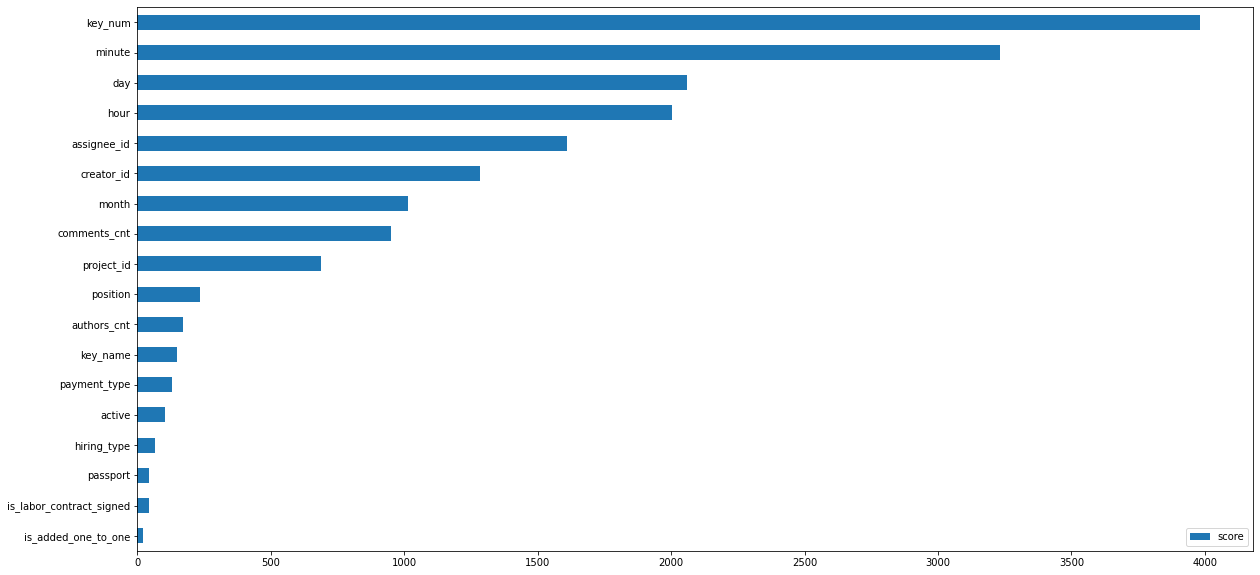

In [123]:
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys,
                    columns=["score"]).sort_values(by="score", ascending=False)
data.nsmallest(40, columns="score").plot(kind='barh', figsize=(20, 10)) ## plot top 40 features

In [45]:
data

,score
assignee_id,97
month,93
creator_id,87
comments_cnt,86
key_name,62
minute,57
hour,48
day,47
project_id,23
year,20


In [47]:
feature_importance

{'key_name': 62,
 'assignee_id': 97,
 'comments_cnt': 86,
 'month': 93,
 'creator_id': 87,
 'authors_cnt': 17,
 'hour': 48,
 'active': 9,
 'payment_type': 19,
 'project_id': 23,
 'minute': 57,
 'is_labor_contract_signed': 5,
 'position': 12,
 'year': 20,
 'day': 47,
 'passport': 1}

# Сабмит на сайт

## Обработка тестовых данных

Считаем данные

In [131]:
df_test = pd.read_csv("./data/test/test_issues.csv")

In [132]:
df_test['created_time'] = pd.to_datetime(df_test['created'], format='%Y-%m-%d %H:%M:%S')
df_test['month'] = df_test['created_time'].dt.month
df_test['day'] = df_test['created_time'].dt.day
df_test['hour'] = df_test['created_time'].dt.hour
df_test['minute'] = df_test['created_time'].dt.minute

df_test['key_name'] = df_test['key'].apply(lambda x: x.split('-')[0])
df_test['key_num'] = df_test['key'].apply(lambda x: x.split('-')[1]).astype('int64')

df_test['clear_summary'] = df_test['summary'].apply(clear_text)
df_test['clear_summary'] = df_test['clear_summary'].str.lower()
df_test['lemm_summary'] = df_test['clear_summary'].apply(lemmatize_text_rus)
df_test['lemm_summary'] = df_test['lemm_summary'].apply(lemmatize_with_pos_eng)

df_test = pd.merge(df_test, df_emp, left_on="assignee_id", right_on="id",
                   how='left', suffixes=('', '_y'))

df_test.drop(['created', 'created_time'], axis=1, inplace=True)
# df_test.drop(['key', 'key_num'], axis=1, inplace=True)
df_test.drop(['key'], axis=1, inplace=True)
df_test.drop(['summary', 'clear_summary'], axis=1, inplace=True)
# df_test.drop(['creator_id', 'assignee_id', 'id_y'], axis=1, inplace=True)
df_test.drop(['lemm_summary', 'id_y'], axis=1, inplace=True)

df_test.head()

,id,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,675975,5,112,112,1,15,9,52,SM,11140,0,devops,staff,fixed,0,0,0,0,0
1,675972,5,112,112,1,15,9,54,SM,11141,0,devops,staff,fixed,0,0,0,0,0
2,675965,5,94,54,1,16,4,46,SM,11144,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0
3,675961,5,94,94,1,16,11,12,SM,11146,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0
4,675955,5,1,54,1,17,5,19,SM,11150,1,other,unknown,unknown,0,0,0,0,0


In [133]:
df_coms_test = pd.read_csv('./data/test/test_comments.csv')
df_coms_counts_test = df_coms_test.groupby('issue_id').agg({'comment_id': 'count',
                                                            'author_id': 'nunique'})
df_coms_counts_test.reset_index(inplace=True)
df_coms_counts_test.rename(columns={"comment_id":"comments_cnt",
                                    "author_id":"authors_cnt"},
                           inplace=True)
df_coms_counts_test.head()

,issue_id,comments_cnt,authors_cnt
0,670929,1,1
1,675825,1,1
2,675831,2,1
3,675834,1,1
4,675836,1,1


In [134]:
df_test = pd.merge(df_test, df_coms_counts_test,
                   left_on="id", right_on="issue_id", how='left')
df_test.drop(['id', 'issue_id'], axis=1, inplace=True)
df_test['comments_cnt'] = df_test['comments_cnt'].fillna(0).astype('int32')
df_test['authors_cnt'] = df_test['authors_cnt'].fillna(0).astype('int32')
df_test.head()

,project_id,assignee_id,creator_id,month,day,hour,minute,key_name,key_num,active,position,hiring_type,payment_type,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,comments_cnt,authors_cnt
0,5,112,112,1,15,9,52,SM,11140,0,devops,staff,fixed,0,0,0,0,0,8,1
1,5,112,112,1,15,9,54,SM,11141,0,devops,staff,fixed,0,0,0,0,0,4,2
2,5,94,54,1,16,4,46,SM,11144,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0,1,1
3,5,94,94,1,16,11,12,SM,11146,0,разработчик мобильных приложений,staff,fixed,0,0,0,0,0,2,2
4,5,1,54,1,17,5,19,SM,11150,1,other,unknown,unknown,0,0,0,0,0,7,2


In [135]:
# X_test_new = count_tf_idf.transform(df_test['lemm_summary'])
# X_test_new_df = pd.DataFrame(X_test_new.toarray(), columns=feature_names_tf)
# df_test.drop('lemm_summary', axis=1, inplace=True)
# X_test = pd.concat([df_test, X_test_new_df], axis=1)

X_test = df_test
X_test[cat_features] = ord_encoder.transform(X_test[cat_features])
X_test.shape

(1070, 20)

In [136]:
pred_test = np.rint(np.exp(model.predict(X_test))).astype('int64')
pred_test

array([ 7241, 12278,  2296, ...,  7274,  5836,  6417])

### Создаем датафрейм с предсказанием

In [137]:
df_sample = pd.read_csv('./data/sample_solution.csv')
len(pred_test), len(df_sample)

(1070, 1070)

In [138]:
df_sample.overall_worklogs = pred_test
df_sample.to_csv('./solutions/xgb_-year+key_num.csv', index=False)

### Проверяем предсказание

In [139]:
df_solution = pd.read_csv('./solutions/xgb_-year+key_num.csv')
df_solution.head()

,id,overall_worklogs
0,675975,7241
1,675972,12278
2,675965,2296
3,675961,4657
4,675955,3105
